In [1]:
import numpy as np
import os
import sys
import copy
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict
import time
import loadmnist
from loadmnist import *
list_pathstoadd = [
    "../../"
]
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
#import generalGPmodule
import localsrc_mnistdemo
from localsrc_mnistdemo import *
import gpex
import resnetformnist
from resnetformnist import *
from gpex.kernelmappings.image import Resnet50BackboneKernelDivideAvgPool
tfm_denormalize = loadmnist.ImgnetDenormalize()

In [2]:
#settings ====
idx_trainingbatch = 1
flag_enabledataaugmentation = True
fname_gpmodel = os.path.join(
    "..",
    "..",
    "Material_PaperResults",
    "Models",
    "ExplainClassifier",
    "mnist_classification.pt"
)

#"../../Material_PaperResults/Models/ExplainClassifier/cifar10.pt"
flag_loadalltraining = True
int_mode_modulekernel = 16
flag_train_memefficient, memefficeint_heads_in_compgraph = False, None
du_per_class = 20
int_exposedclass = None
idx_split = 0
dim_wideoutput = 1024
flag_loadalltraining = False
num_classes = 10
batchsize = 10
flag_efficient = True
flag_detachcovpvn = True
flag_controlvariate = True
flag_setcovtoOne = False
int_mode_controlvariate = 2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
rootpath_ds = os.path.join(
    "..",
    "..",
    "Material_PaperResults",
    "Datasets",
    "MNIST"
)

ds_train = MNISTDataset(
    rootdir = rootpath_ds,
    str_trainortest = "train",
    flag_enabledataaugmentation = False
)
ds_inducing = MNISTDataset(
    rootdir = rootpath_ds,
    str_trainortest = "train",
    flag_enabledataaugmentation = False
)
ds_test = MNISTDataset(
    rootdir = rootpath_ds,
    str_trainortest = "test",
    flag_enabledataaugmentation = False
)

In [5]:
dl_train = DataLoader(ds_train, batch_size=batchsize,
                      shuffle=True, num_workers=0)
dl_inducing = DataLoader(ds_inducing, batch_size=batchsize,
                          shuffle=True, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=batchsize,
                     shuffle=False, num_workers=0)

In [6]:
model = MainModule(
    dim_wideoutput=dim_wideoutput,
    num_classes = num_classes,
    device = device,
    ds_inducing = ds_inducing,
    dl_recurring = dl_inducing,
    dl_nonrecurring = dl_train,
    dl_test = dl_test,
    batchsize = batchsize
)

model.to(device)
print("Model was created in {}.".format(device))

>>>>>>> self.dim_wideoutput = 1024
C_head is equal to 2048.
<><><><><><><><><> finisehd creating module_tail <><><><><><><><>.
Model was created in cuda:0.


In [7]:
#model.n_subsampleminibatch = 2
gpexmodule = gpex.GPEXModule(
    module_rawmodule = model,
    size_recurringdataset = len(ds_inducing),
    device = device,
    func_mainmodule_to_moduletobecomeGP = model.func_mainmodule_to_moduletobecomeGP, 
    func_feed_noise_minibatch = model.func_feed_noise_minibatch,
    func_feed_inducing_minibatch = model.func_feed_inducing_minibatch,
    func_feed_nonrecurring_minibatch = model.func_feed_nonrecurring_minibatch,
    func_feed_test_minibatch = model.func_feed_test_minibatch,
    func_get_indices_lastrecurringinstances = model.func_get_indices_lastrecurringinstances,
    func_get_modulef1 = model.func_get_modulef1
)
gpexmodule.sigma2_GP = 1.0 #TODO:check
gpexmodule.to(device)
print("gpmodel was created on {}".format(device))

Controlvariate mode is set to 2
x.shape = torch.Size([10, 3, 80, 80])
    Dv was set to 10
x.shape = torch.Size([10, 3, 80, 80])
    Dv was set to 10
gpmodel was created on cuda:0


In [8]:
#load model from checkpoint ====
gpexmodule.load_state_dict(
    torch.load(
        fname_gpmodel
     ),
    strict = True
)
gpexmodule.train()
gpexmodule.to(device)
gpexmodule.renew_precomputed_XTX()
print("gpmodel was loaded from checkpoint.")

gpmodel was loaded from checkpoint.


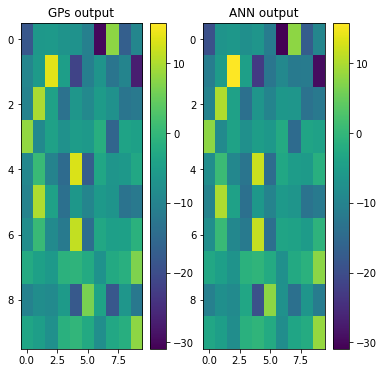

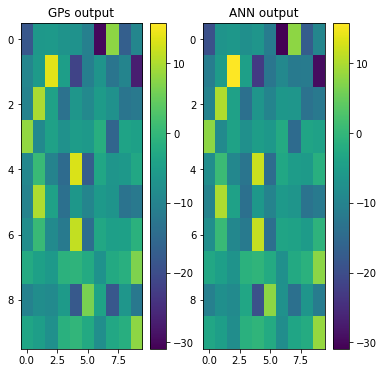

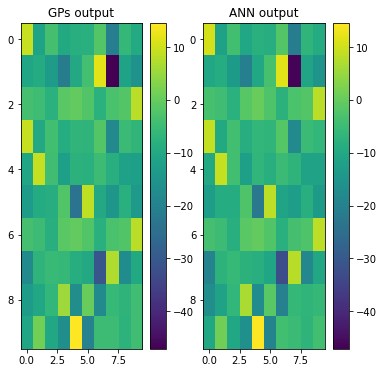

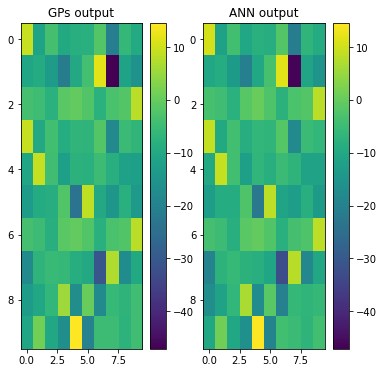

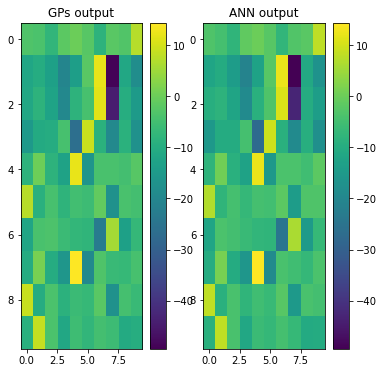

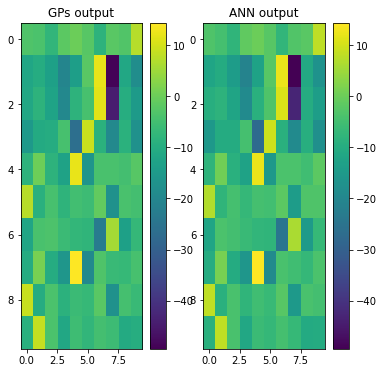

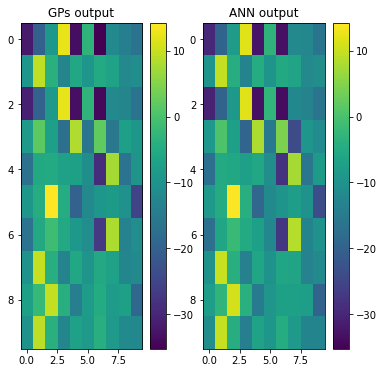

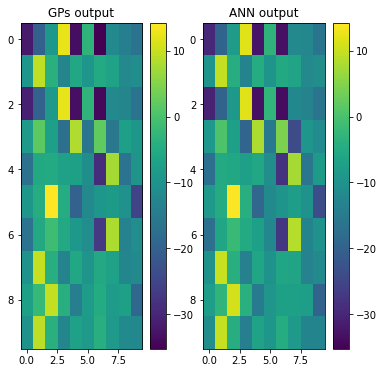

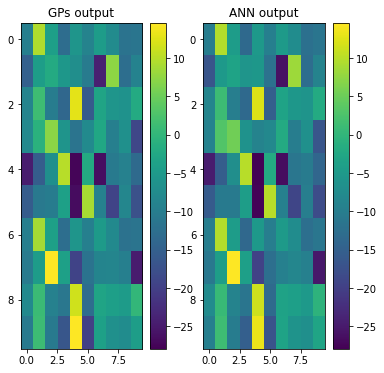

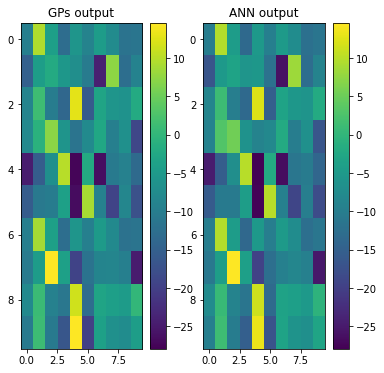

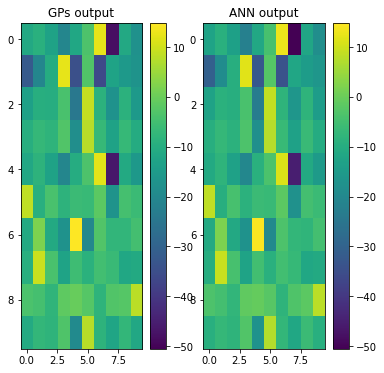

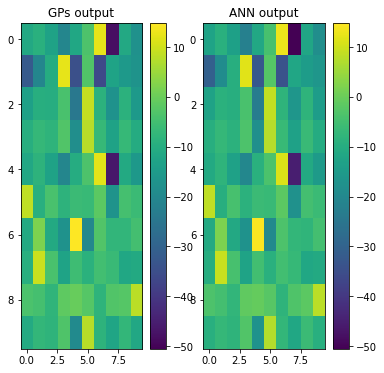

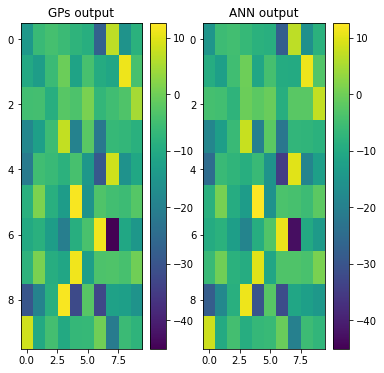

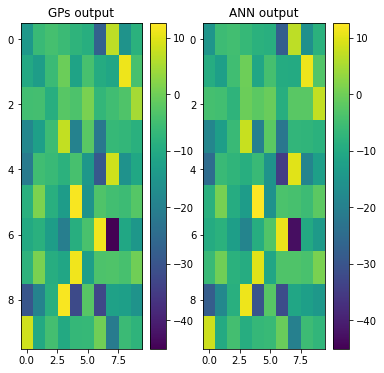

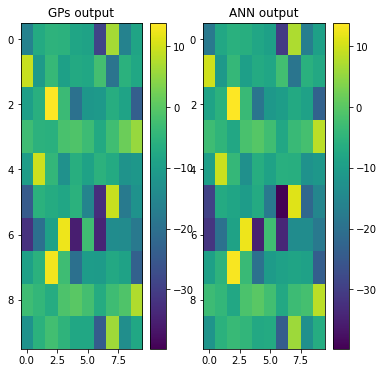

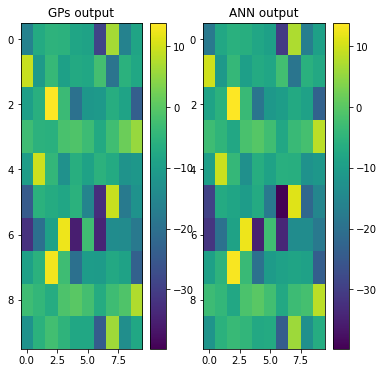

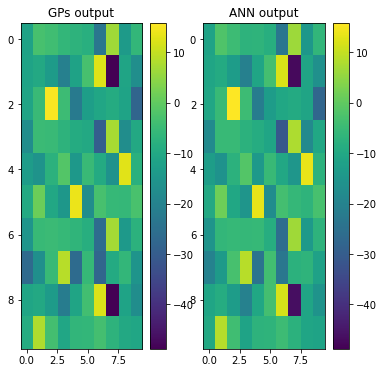

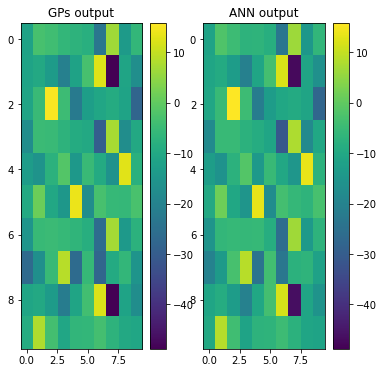

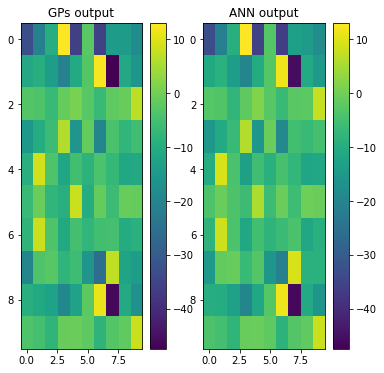

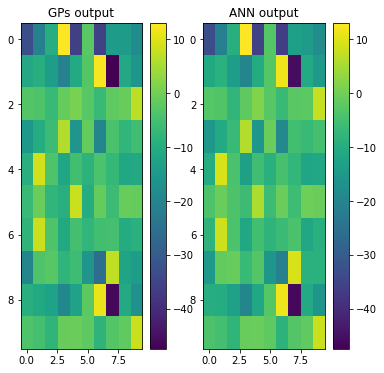

In [9]:
#check if g(.) and GP path match on test instances ====
gpexmodule.renew_precomputed_XTX()
list_outputgpoutputg = gpexmodule.checkequal_GPout_ANNout_ontest(10)
for n in range(len(list_outputgpoutputg)):
    a = list_outputgpoutputg[n][0]
    b = list_outputgpoutputg[n][1]
    
    
    min_ab = min(np.min(a), np.min(b))
    max_ab = max(np.max(a), np.max(b))
        
    plt.figure(figsize=(6,6))
    plt.subplot(1,2,1)
    plt.imshow(np.round(a, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
    plt.title("GPs output")
    plt.subplot(1,2,2)
    plt.imshow(np.round(b, 2), vmin=min_ab, vmax=max_ab, aspect="auto"); plt.colorbar()
    plt.title("ANN output")
    plt.show()        

# Compute Correlation Coefficients

In [10]:
import gpex.evaluation
from gpex.evaluation import GPdiffANN_ontorchdl
from sklearn.metrics import cohen_kappa_score
from scipy import stats

output, dict_gt = GPdiffANN_ontorchdl(
    gpmodel = gpexmodule,
    dl_input = dl_test,
    input_device = device
)

np_gpann = np.array(
    [output[k] for k in output.keys()]
)
np_gt = np.array([dict_gt[k] for k in output.keys()])

numclasses = int(np_gpann.shape[1]/2)
list_correlation = []
for c in range(numclasses):
    list_correlation.append(
        stats.pearsonr(np_gpann[:, c], np_gpann[:, c+numclasses])[0]
    )
print("list correlation = {}".format(np.round(list_correlation, 3)))
gp_labels = np.argmax(np_gpann[:, 0:numclasses], 1)
ann_labels = np.argmax(np_gpann[:, numclasses::], 1)
acc_ann = np.sum(ann_labels == np_gt)/np_gpann.shape[0]
acc_gp = np.sum(gp_labels == np_gt)/np_gpann.shape[0]
print("Acuuray of ANN {}".format(acc_ann))
print("   Acuuracy of GP {}".format(acc_gp))

list correlation = [0.993 0.995 0.994 0.996 0.995 0.993 0.995 0.995 0.993 0.991]
Acuuray of ANN 0.9956
   Acuuracy of GP 0.9941


# Depict the Correlation Scatters

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


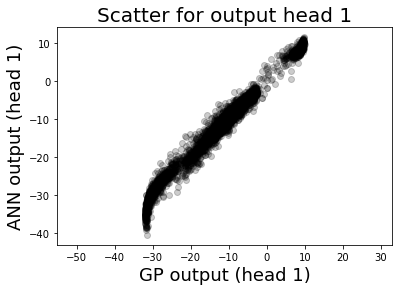

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


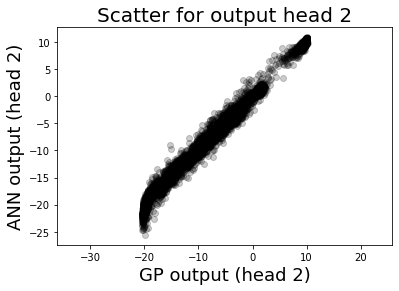

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


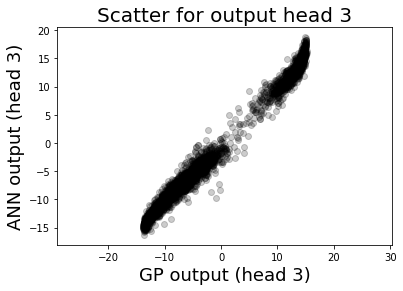

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


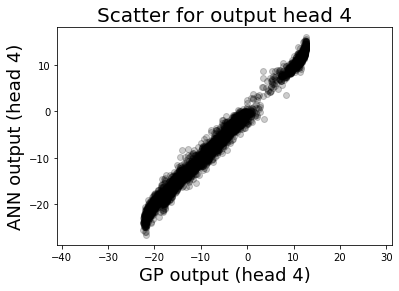

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


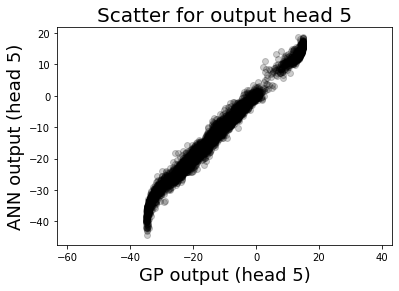

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


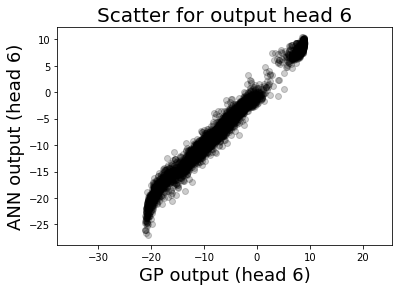

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


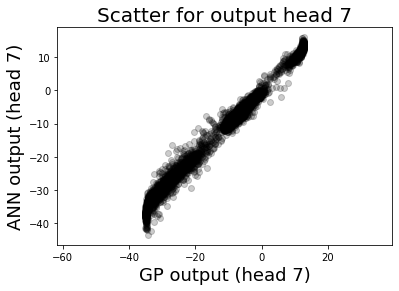

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


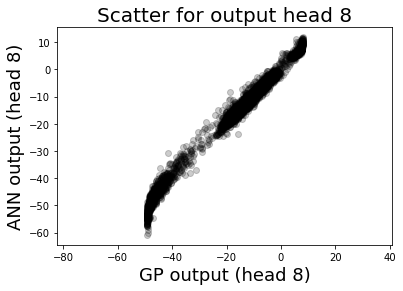

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


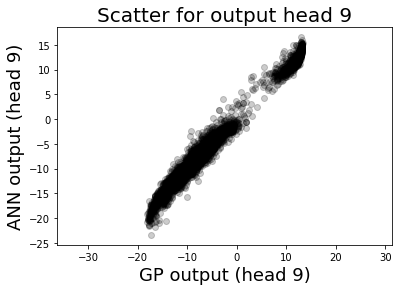

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


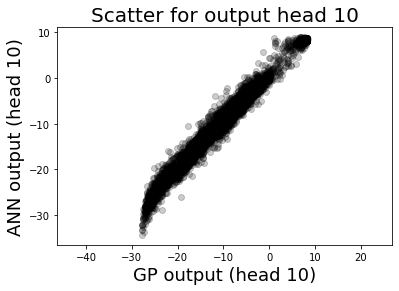

In [11]:
from scipy.special import softmax
np_gp = np_gpann[:,0:num_classes]
np_ann = np_gpann[:,num_classes::]
np_gp_softmax = softmax(np_gp, 1)
np_ann_softmax = softmax(np_ann, 1)

list_disaggrement = (np.argmax(np_gp, 1) != np.argmax(np_ann, 1)).tolist()
list_c = [0,0,0,0.2] #[[1,0,0,1] if(u==True) else [0,0,0,0.05] for u in list_disaggrement]
count_plotted = 0
for c in range(num_classes):
    plt.ioff()
    plt.figure()
    plt.scatter(np_gp[:,c], np_ann[:,c], c=np.array(list_c), marker='o', facecolors='none')
    plt.axis("equal")
    plt.xlabel("GP output (head {})".format(c+1), fontsize=18)
    plt.ylabel("ANN output (head {})".format(c+1), fontsize=18)
    plt.title("Scatter for output head {}".format(count_plotted+1), fontsize=20)
    count_plotted += 1
    plt.show()

# Inspect Nearest Neighbours

In [12]:
def inspect_NNs(model_input, ds_input, input_device):
    model_input.eval()
    toret = []
    list_gty = []
    list_uncertainty = []
    list_similarities = []
    list_x, list_y = [], []
    list_output_g = []
    for n in range(len(ds_input)):
        print(" instance {} from {}".format(n, len(ds_input)), end='\r')
        x, y, _ = ds_input[n]
        output, uncertainty, output_similarities = \
                model_input.testingtime_forward(x.unsqueeze(0).to(input_device), y, n)
        #print("output_similaritites.shape = {}".format(output_similarities.shape))
        output = output[0]
        toret.append(output.detach().cpu().numpy())
        list_gty.append(y)
        list_uncertainty.append(uncertainty)
        list_similarities.append(output_similarities.detach().cpu().numpy())
        list_x.append(x); list_y.append(y)
        #feed the model to g(.) ====
        output_g, _, _ = \
                model_input.module_rawmodule(x.unsqueeze(0).to(input_device), y, n)
        list_output_g.append(output_g.detach().cpu().numpy().flatten().tolist())

    print("\n")
    toret = np.array(toret)
    toret = toret[:,0,:]
    output_g = np.array(list_output_g)
    print(output_g.shape)
    model_input.train()
    return toret, list_gty, list_uncertainty, list_similarities, list_x, list_y, output_g

In [13]:
list_retval_inspectmodel = [inspect_NNs(gpexmodule, ds_test, device)]

 instance 9999 from 10000

(10000, 10)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

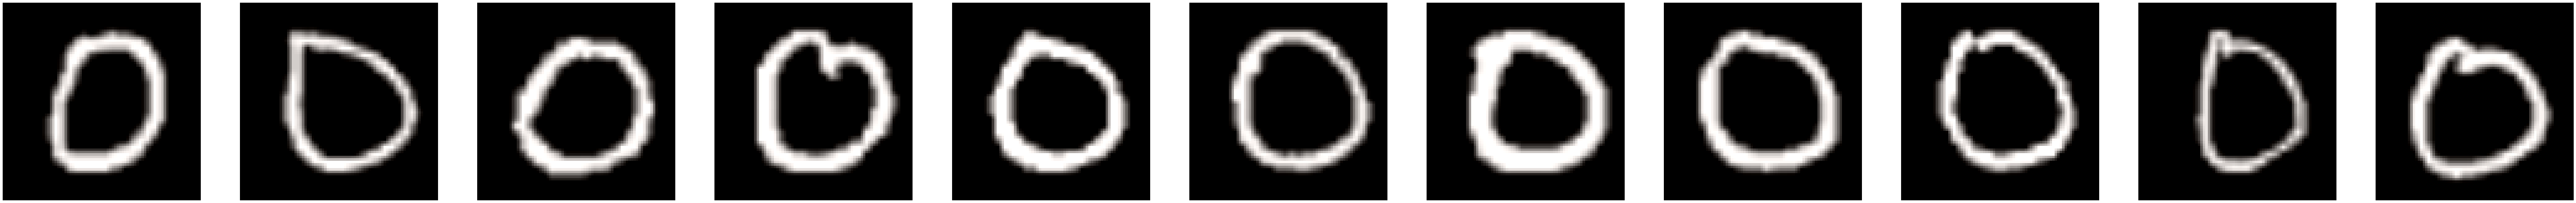

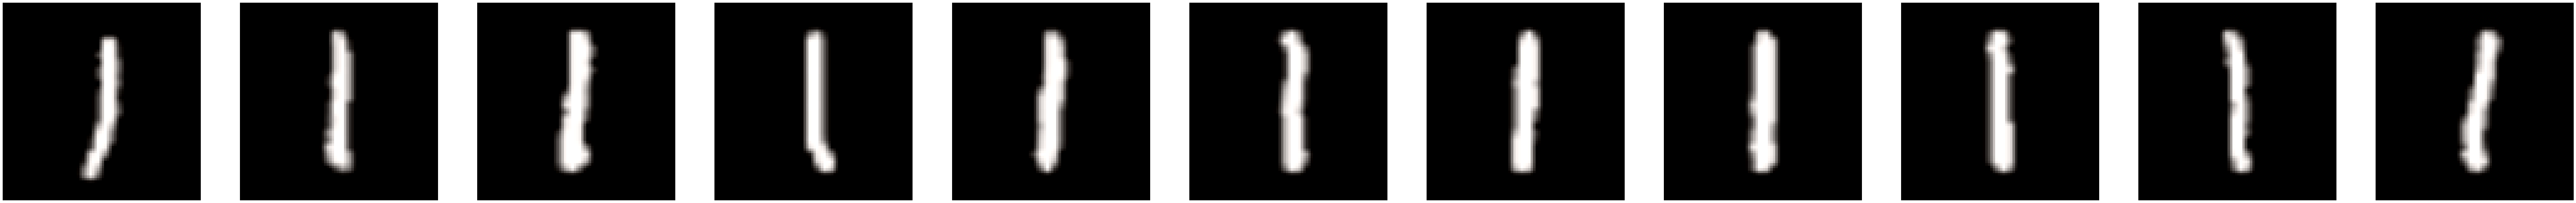

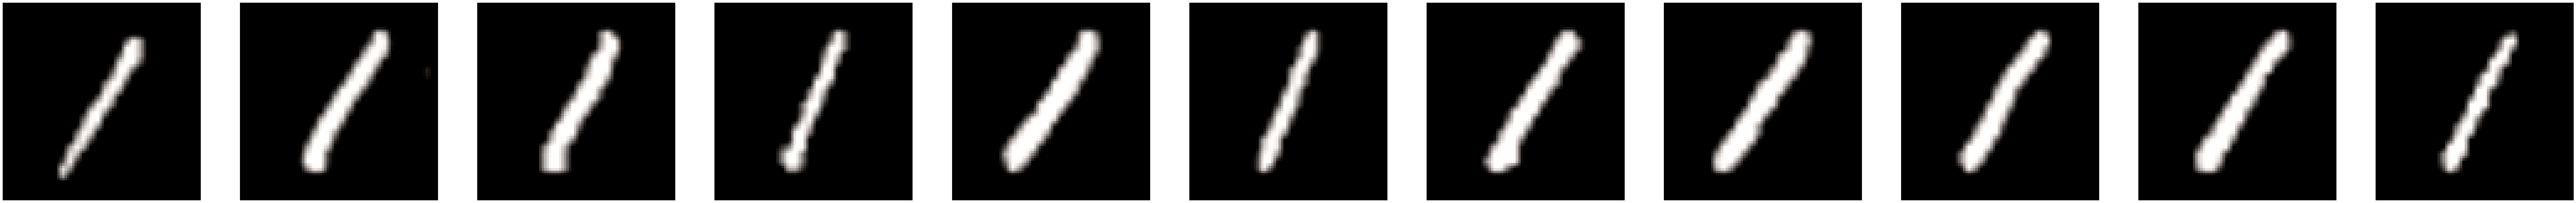

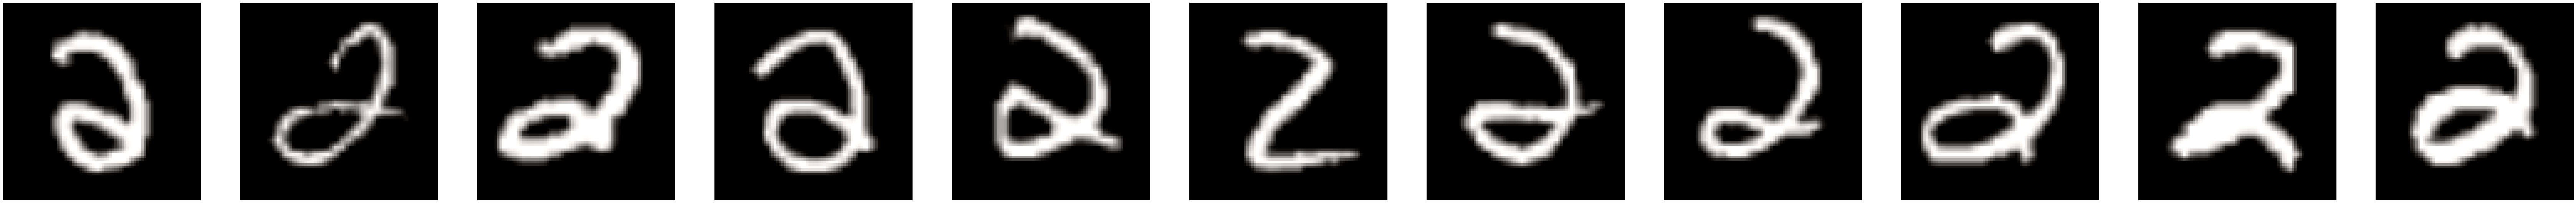

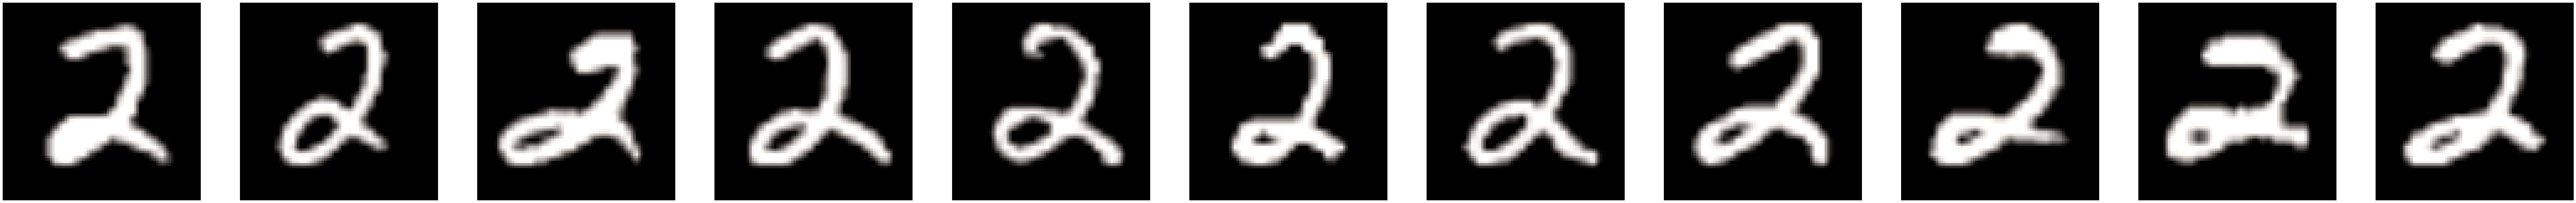

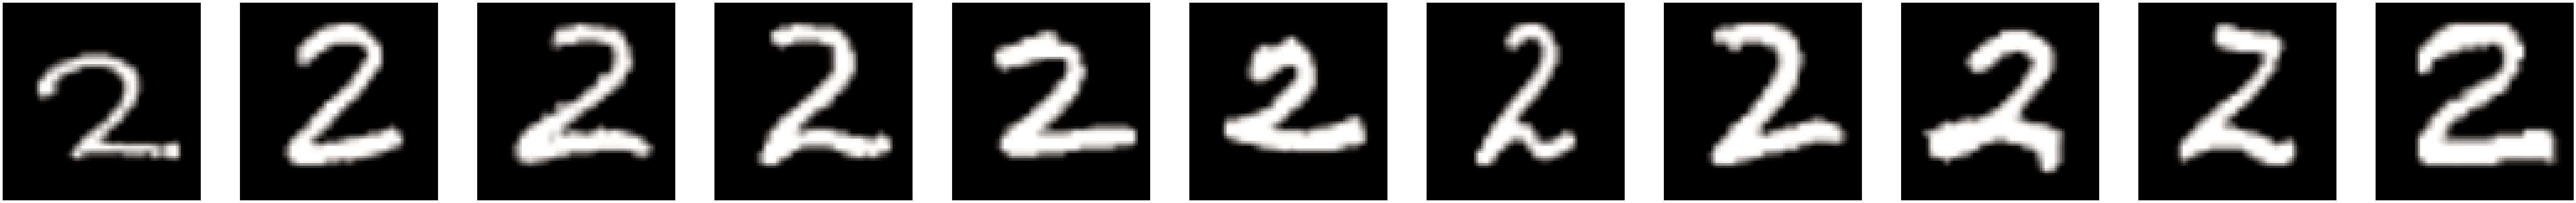

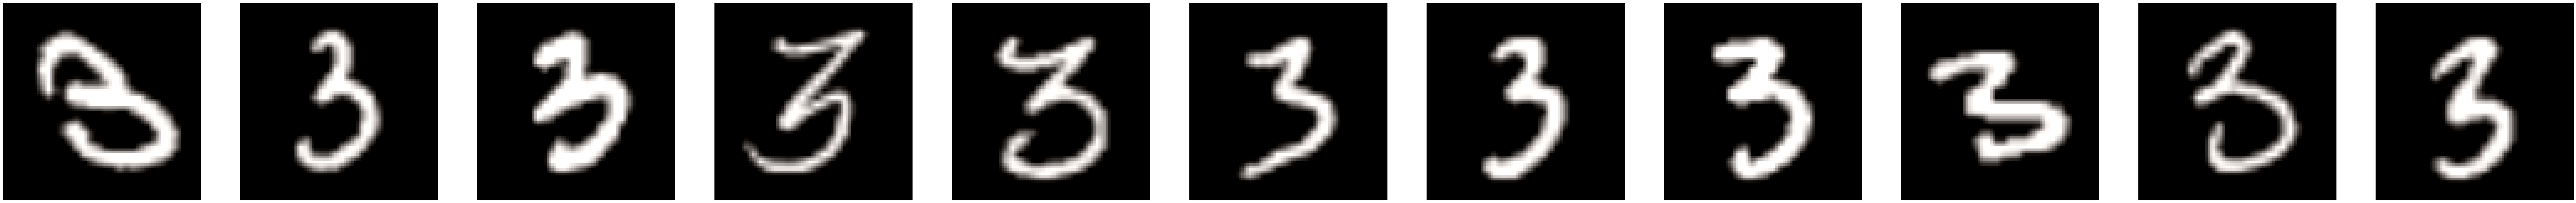

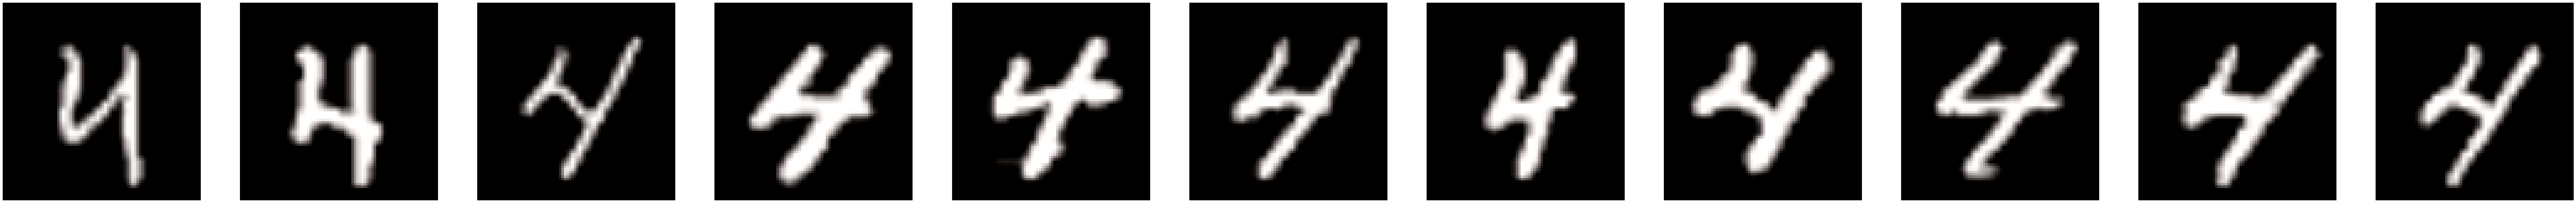

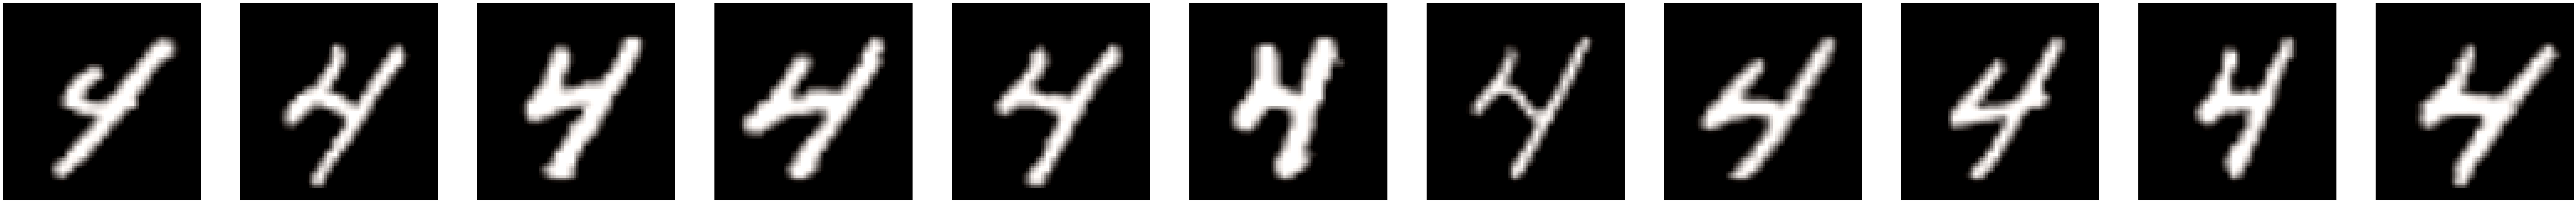

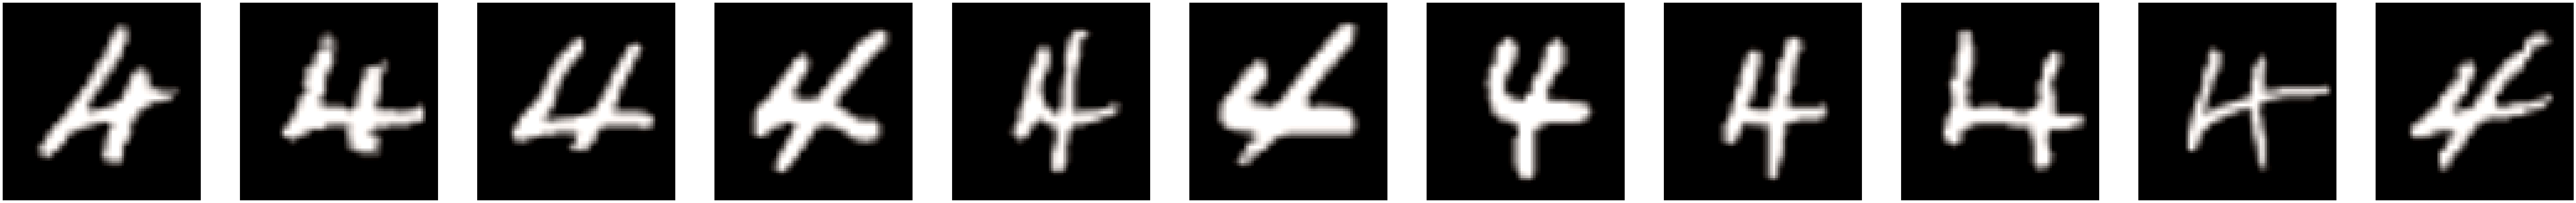

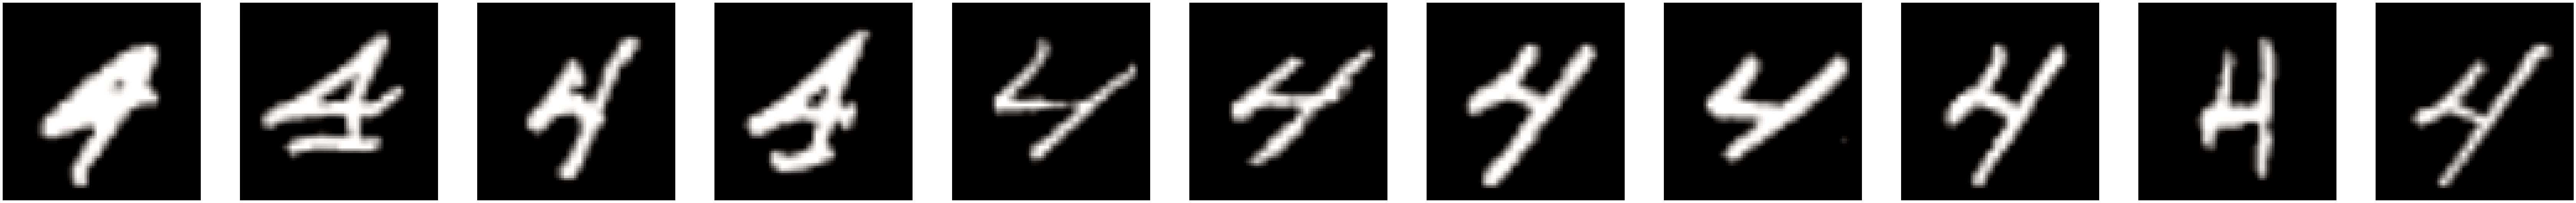

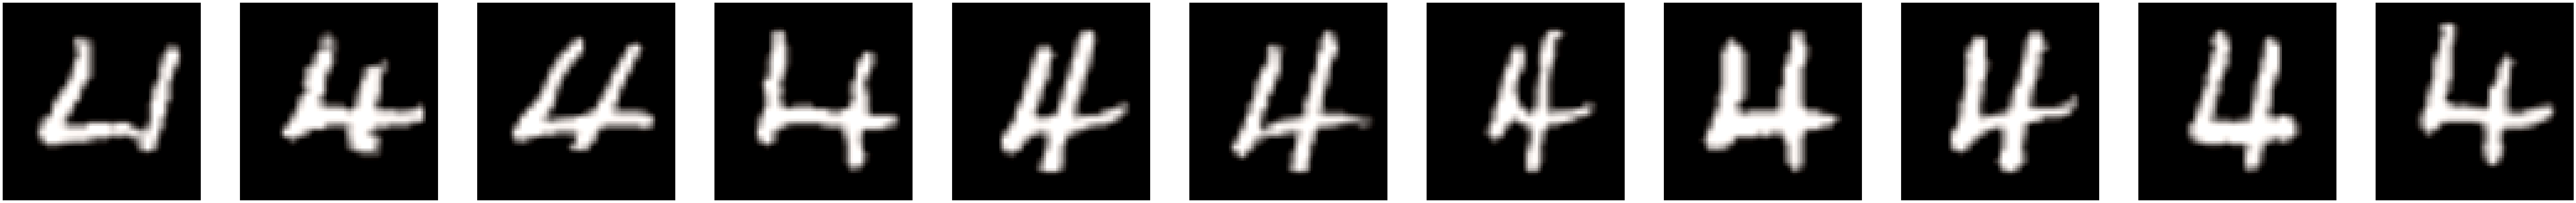

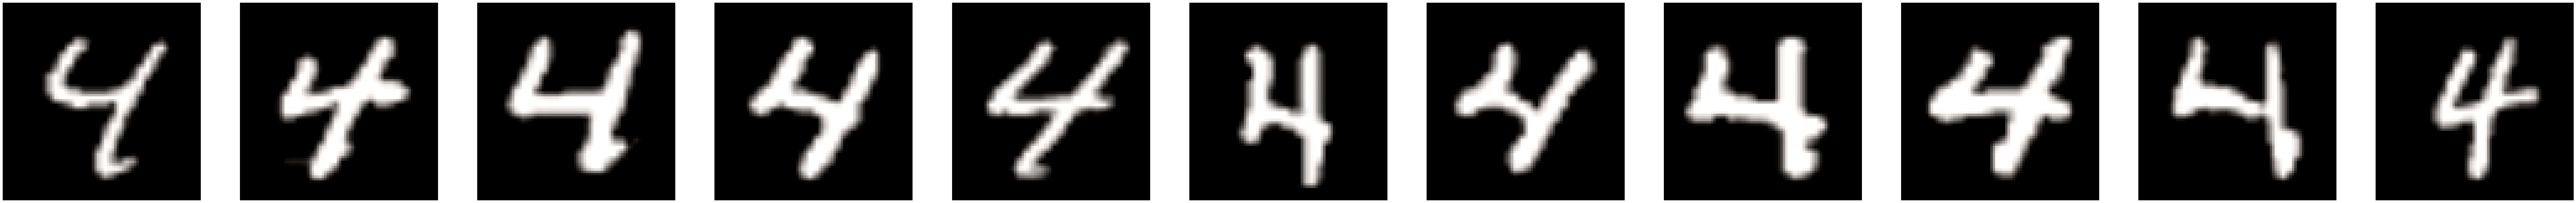

In [14]:
# the two instances for the introduction of the paper ====
#%%capture
m = 10
list_shownn = [10, 393, 388, 221, 82, 77, 18, 789, 670, 610, 447, 33, 6]
for n in list_shownn:
    
    plt.figure(figsize=((m+2)*10, 2*10))
    count_subplot = 1
    
    _, list_gty, _, _, list_x, list_y, _ = list_retval_inspectmodel[0]
    x, y = list_x[n], list_y[n]
    
    
    str_subfolder = ""
    idx_model = 0 #for idx_model in range(len(list_retval_inspectmodel)):
    list_predy, list_gty, list_uncertainty, list_similarities, _, _, output_g = \
                        list_retval_inspectmodel[idx_model]
    np_argmax_list_predyn = np.argmax(output_g[n])
    if(np_argmax_list_predyn == list_gty[n]):
        str_subfolder = str_subfolder + "True"
    else:
        str_subfolder = str_subfolder + "False"
    kn = list_similarities[n][np_argmax_list_predyn, :].flatten()
    idx_similars = np.argsort(-kn).tolist()[0:m]
    plt.ioff()
    plt.subplot(1, 1*(m+1), count_subplot); count_subplot+=1;
    plt.imshow(tfm_denormalize(x).cpu().numpy().transpose(1,2,0))
    plt.axis('off')
    
    for count_similars in range(len(idx_similars)):
        plt.subplot(1, 1*(m+1), count_subplot); count_subplot+=1;
        plt.imshow(
          tfm_denormalize(
                  ds_inducing[idx_similars[count_similars]][0]
              ).cpu().numpy().transpose(1,2,0),
        )
        plt.axis('off')

plt.show()